In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import time 
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [3]:
## population and age classes
M=4  ## number of age classes

my_data = np.genfromtxt('../data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni0=aM+aF;   Ni=np.zeros((M))

# scale the population down to a more manageble level 
Ni[0] = (np.sum(Ni0[0:4])/1e4).astype('int')
Ni[1] = (np.sum(Ni0[4:8])/1e4).astype('int')
Ni[2] = (np.sum(Ni0[8:12])/1e4).astype('int')
Ni[3] = (np.sum(Ni0[12:16])/1e4).astype('int')
N=np.sum(Ni)
fi = Ni/N 

# Get individual contact matrices
CH0, CW0, CS0, CO0 = pyross.contactMatrix.India()


CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))


for i in range(M):
    for j in range(M):
        i1, j1 = i*4, j*4
        CH[i,j] = np.sum( CH0[i1:i1+4, j1:j1+4] )
        CW[i,j] = np.sum( CW0[i1:i1+4, j1:j1+4] )
        CS[i,j] = np.sum( CS0[i1:i1+4, j1:j1+4] )
        CO[i,j] = np.sum( CO0[i1:i1+4, j1:j1+4] )

In [5]:
# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.SIR(CH, CW, CS, CO)

times= [20] # temporal boundaries between different contact-behaviour

aW, aS, aO = 0.7, 0.6, 0.5

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # after first time
                ]         

# generate corresponding contact matrix function
C = generator.interventions_temporal(times=times,interventions=interventions)

In [8]:
beta  = 0.00454      # contact rate parameter
gIa   = 1./7            # recovery rate of asymptomatic infectives 
gIs   = 1./7            # recovery rate of symptomatic infectives 
alpha = 0.2              # asymptomatic fraction
fsa   = 0.8               # suppresion of contact by symptomatics


# initial conditions    
Is_0 = np.ones(M)*100
Is_0[1] += 100 #make one group different 
Ia_0 = np.zeros((M))*20
Ia_0[1] += 20
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.stochastic.SIR(parameters, M, Ni)

contactMatrix=C

# start simulation
Tf=80;  Nf=Tf+1 
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)
np.save('cal_lat_SIR_traj.npy', data['X'])

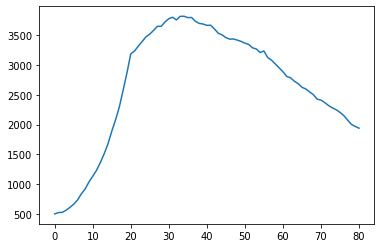

In [9]:
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t']
plt.plot(t, IC)
plt.show() 

### Compare the deterministic trajectory and the stochastic one before intervention

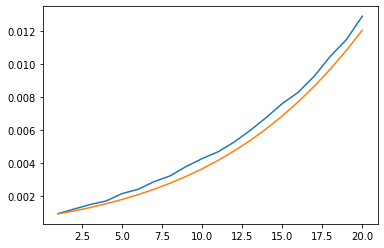

In [10]:
Tf_initial = 20 # truncate to only getting the first few datapoints 
Nf_initial = Tf_initial+1

x = np.load('cal_lat_SIR_traj.npy')
x = (x/N)[:Nf_initial]
steps = 101 # number internal integration steps taken

fltr=np.repeat(np.array([False, False, True]), M)
obs=x[:, fltr] 

contactMatrix = generator.constant_contactMatrix()
det_model = pyross.deterministic.SIR(parameters, int(M), fi)
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)
xm,full_cov = estimator.obtain_full_mean_cov(x[0], Tf_initial, Nf_initial, det_model, contactMatrix)
t = np.linspace(1, Tf_initial, Nf_initial-1)
plt.plot(t, x[1:,2*M])
plt.plot(t, xm[:,2*M])
plt.show()

In [11]:
# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x[0], obs[1:], fltr, Tf_initial, Nf_initial, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-658.037110483999
0.28002405166625977


In [12]:
# take a guess 
beta_g = 0.005
gIa_g = 0.15
gIs_g = 0.15
alpha_g = 0.25
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g])


eps = 1e-3 # step used to calculate hessian in the optimisation algorithm 

alpha_g = 0.25
alpha_bounds = (0.1, 0.4)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.005
beta_bounds = (1e-3, 0.01)

gIa_g = 0.12
gIa_bounds = (0.1, 0.2)

gIs_g = 0.14
gIs_bounds = (0.13, 0.15) 

fsa_g = 0.8

Is0_g = Is_0/N 
bounds_for_Is = [(80/N, 120/N)]*M 
bounds_for_Is[1] = (180/N, 220/N)

Ia0_g = Ia_0/N
bounds_for_Ia = [(1/N, 100/N)]*M


S0_g = S_0/N
bounds_for_S = [(fi[i]-400/N, fi[i]-bounds_for_Is[i][0]/N) for i in range(M)]


# optimisation parameters 
ftol = 1e-4 # the relative tol in (-logp)  
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g, *Is0_g])
params = estimator.latent_inference(guess, obs, fltr, Tf_initial, Nf_initial, contactMatrix,
                                    bounds, beta_rescale=40, verbose=True, niter=2, ftol=ftol, eps=eps)
# the L-BFGS-B method prints to the terminal rather than here 

parameters: [0.23134572 0.1801021  0.12994895 0.14124362]
parameters: [0.22757483 0.17615257 0.13195087 0.14155841]
parameters: [0.22832474 0.17713545 0.13158562 0.14147623]
parameters: [0.22835656 0.17753412 0.13162458 0.14144034]
parameters: [0.22725878 0.17829904 0.13248217 0.141376  ]
parameters: [0.22498146 0.17815409 0.13393762 0.14149543]
parameters: [0.22048498 0.1782638  0.13592441 0.14318727]
parameters: [0.21739995 0.17825325 0.13689894 0.14455987]
parameters: [0.21552443 0.17834234 0.13720264 0.14550776]
parameters: [0.2126679  0.17864013 0.13722466 0.14698837]
parameters: [0.20815001 0.17918215 0.1365106  0.14905967]
parameters: [0.20089382 0.17876917 0.13355036 0.15      ]
parameters: [0.19505428 0.17446067 0.11778456 0.14716617]
parameters: [0.20058074 0.17235746 0.11321538 0.1445518 ]
parameters: [0.20382834 0.17077938 0.11050171 0.14261756]
basinhopping step 0: f -662.139
parameters: [0.10782967 0.15129695 0.17181999 0.13506444]
parameters: [0.10779079 0.15468976 0.170

In [13]:
# save the parameters 
np.save('SIR_cal_lat_param.npy', params)

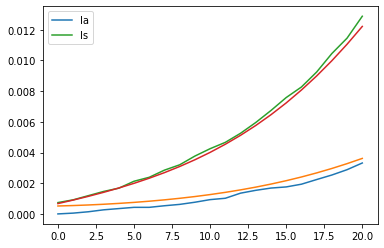

In [14]:
# check the predictions 
params = np.load('SIR_cal_lat_param.npy')
x = np.load('cal_lat_SIR_traj.npy')/N
parameters = {'alpha':params[0], 'beta':params[1], 'gIa':params[2], 'gIs':params[3],'fsa':0.8}
estimator.set_params(parameters)
x0 = params[4:]
det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x_det = estimator.integrate(x0, 0, Tf_initial, Nf_initial, det_model, contactMatrix)
plt.plot(x[:Nf_initial,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:Nf_initial,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()

In [15]:
aW_g = 0.6 
aW_bounds = [0.2, 0.8]
aS_g = 0.6
aS_bounds = [0.2, 0.8]
aO_g = 0.6
aO_bounds = [0.2, 0.8]
guess = np.array([aW_g, aS_g, aO_g])
bounds = np.array([aW_bounds, aS_bounds, aO_bounds])

x = np.load('cal_lat_SIR_traj.npy')/N
x = x[Nf_initial:]
obs = x[:, fltr]
Nf_control = x.shape[0] 
Tf_control = Nf_control-1 

det_model = pyross.deterministic.SIR(parameters, M, fi)
contactMatrix = generator.constant_contactMatrix()
x0 = estimator.integrate(params[-3*M:], 0, Tf_initial, 2, det_model, contactMatrix)[-1]
x0 = np.array(x0)
times = [Tf+1]
interventions = [[aW, aS, aO]]
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

# compute -log_p for the initial guess (for the moment, use correct parameters)
parameters = estimator.make_params_dict(params)
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_control, Nf_control, contactMatrix)
print(logp) 

-1876.4443269869616


In [16]:
eps = 1e-3 
start_time = time.time() 

parameters = estimator.make_params_dict(params)
estimator.set_params(parameters) 
control_params = estimator.latent_infer_control(guess, x0, obs, fltr, Tf_control, Nf_control, generator, bounds,
                                  niter=2, eps=eps, verbose=True)
end_time = time.time()
print(control_params) # best guess 
print(end_time - start_time)

parameters: [0.50459014 0.50459014 0.50459014]
parameters: [0.5595957  0.5459276  0.54606261]
parameters: [0.60256061 0.53345913 0.53157963]
parameters: [0.67049053 0.52715318 0.51395629]
parameters: [0.68126667 0.54568209 0.50462684]
parameters: [0.71486217 0.61387981 0.46643279]
parameters: [0.72264812 0.63523205 0.45221863]
parameters: [0.72314689 0.64025203 0.448098  ]
basinhopping step 0: f -1878.5
parameters: [0.72220326 0.66034048 0.44494882]
parameters: [0.72182577 0.65805916 0.44057427]
parameters: [0.72240484 0.65712123 0.43993357]
basinhopping step 1: f -1878.45 trial_f -1878.45 accepted 1  lowest_f -1878.5
parameters: [0.5852466  0.60142786 0.43383551]
parameters: [0.64934839 0.65728356 0.46645919]
parameters: [0.65376055 0.65304815 0.46409587]
parameters: [0.68676613 0.63909707 0.45585933]
parameters: [0.7161391  0.63218153 0.45173209]
parameters: [0.71984819 0.63409659 0.45179637]
basinhopping step 2: f -1878.5 trial_f -1878.5 accepted 1  lowest_f -1878.5
found new global

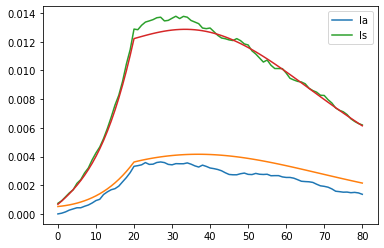

In [17]:
times = [20]
interventions = [[1.0,1.0,1.0],      # before first time
                 control_params,       # after first time
                ]         

# compare the true trajectory with the 
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)
det_model = pyross.deterministic.SIR(parameters, M, fi)
x0 = params[4:]
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('cal_lat_SIR_traj.npy')/N
plt.plot(x[:,1*M], label='Ia')
plt.plot(x_det[:, 1*M])
plt.plot(x[:,2*M], label='Is')
plt.plot(x_det[:, 2*M])
plt.legend()
plt.show()